In [1]:
!pip install -U pyspark

Defaulting to user installation because normal site-packages is not writeable


# Предсказание стоимости жилья в Калифорнии

В проекте требуется обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. 


<font color='green'>Цель</font>

Предсказать медианную стоимость жилья.

<font color='green'>Задачи</font>

- загрузить и исследовать данные;
- построить модели Линейной регрессии;
- проанализировать результаты.

<font color='green'>Основные условия</font>

Основные метрики: MAE, RMSE и R2.

<font color='green'>Файлы</font>

- `housing.csv`

<font color='green'>Признаки</font>

- `longitude` — широта;
- `latitude` — долгота;
- `housing_median_age` — медианный возраст жителей жилого массива;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива;
- `ocean_proximity` — близость к океану.


<font color='green'>Целевой признак</font>

- `median_house_value` — медианная стоимость дома в жилом массиве.



<font color='green'>Содержание</font>

<h1><span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-исследование-данных" data-toc-modified-id="Загрузка-и-исследование-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и исследование данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Tрансформация-категорийных-признаков" data-toc-modified-id="Tрансформация-категорийных-признаков-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Tрансформация категорийных признаков</a></span></li><li><span><a href="#Трансформация-числовых-признаков" data-toc-modified-id="Трансформация-числовых-признаков-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Трансформация числовых признаков</a></span></li><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Разделение на выборки</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия-на-базе-категориальных-и-числовых-данных" data-toc-modified-id="Линейная-регрессия-на-базе-категориальных-и-числовых-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия на базе категориальных и числовых данных</a></span></li><li><span><a href="#Линейная-регрессия-на-базе-числовых-данных" data-toc-modified-id="Линейная-регрессия-на-базе-числовых-данных-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия на базе числовых данных</a></span></li></ul></li><li><span><a href="#Анализ-результатов" data-toc-modified-id="Анализ-результатов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ результатов</a></span></li></ul></div>

## Загрузка и исследование данных

In [2]:
import pandas as pd 

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import six

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
RANDOM_SEED = 1234

spark = SparkSession.builder \
                    .master("local") \
                    .appName("EDA California Housing") \
                    .getOrCreate()

In [4]:
df_housing = spark.read.load('/ML/datasets/housing.csv', format="csv", sep=",", inferSchema=True, header="true")

In [5]:
df_housing.toPandas().head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



Колонка `ocean_proximity` имеет строковой тип данных.

In [7]:
df_housing.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
longitude,20640,-119.56970445736148,2.003531723502584,-124.35,-114.31
latitude,20640,35.6318614341087,2.135952397457101,32.54,41.95
housing_median_age,20640,28.639486434108527,12.58555761211163,1.0,52.0
total_rooms,20640,2635.7630813953488,2181.6152515827944,2.0,39320.0
total_bedrooms,20433,537.8705525375618,421.38507007403115,1.0,6445.0
population,20640,1425.4767441860465,1132.46212176534,3.0,35682.0
households,20640,499.5396802325581,382.3297528316098,1.0,6082.0
median_income,20640,3.8706710029070246,1.899821717945263,0.4999,15.0001
median_house_value,20640,206855.81690891474,115395.61587441359,14999.0,500001.0


В столбце `total_bedrooms` имеются пропущенные значения. Их доля 1%, поэтому просто удалим эти данные.

In [8]:
df_housing = df_housing.na.drop(subset='total_bedrooms')

Удалим явные дубликаты если они есть.

In [9]:
print(df_housing.count())
df_housing = df_housing.dropDuplicates()
print(df_housing.count())

20433
20433


In [10]:
df_housing.filter(F.col('median_house_value') > (480000)).count()

1072

Будем считать вбросами значения целевой переменной > 480000.

In [11]:
df_housing = df_housing.filter(F.col('median_house_value') <= 480000)

Посмотрим на корреляции.

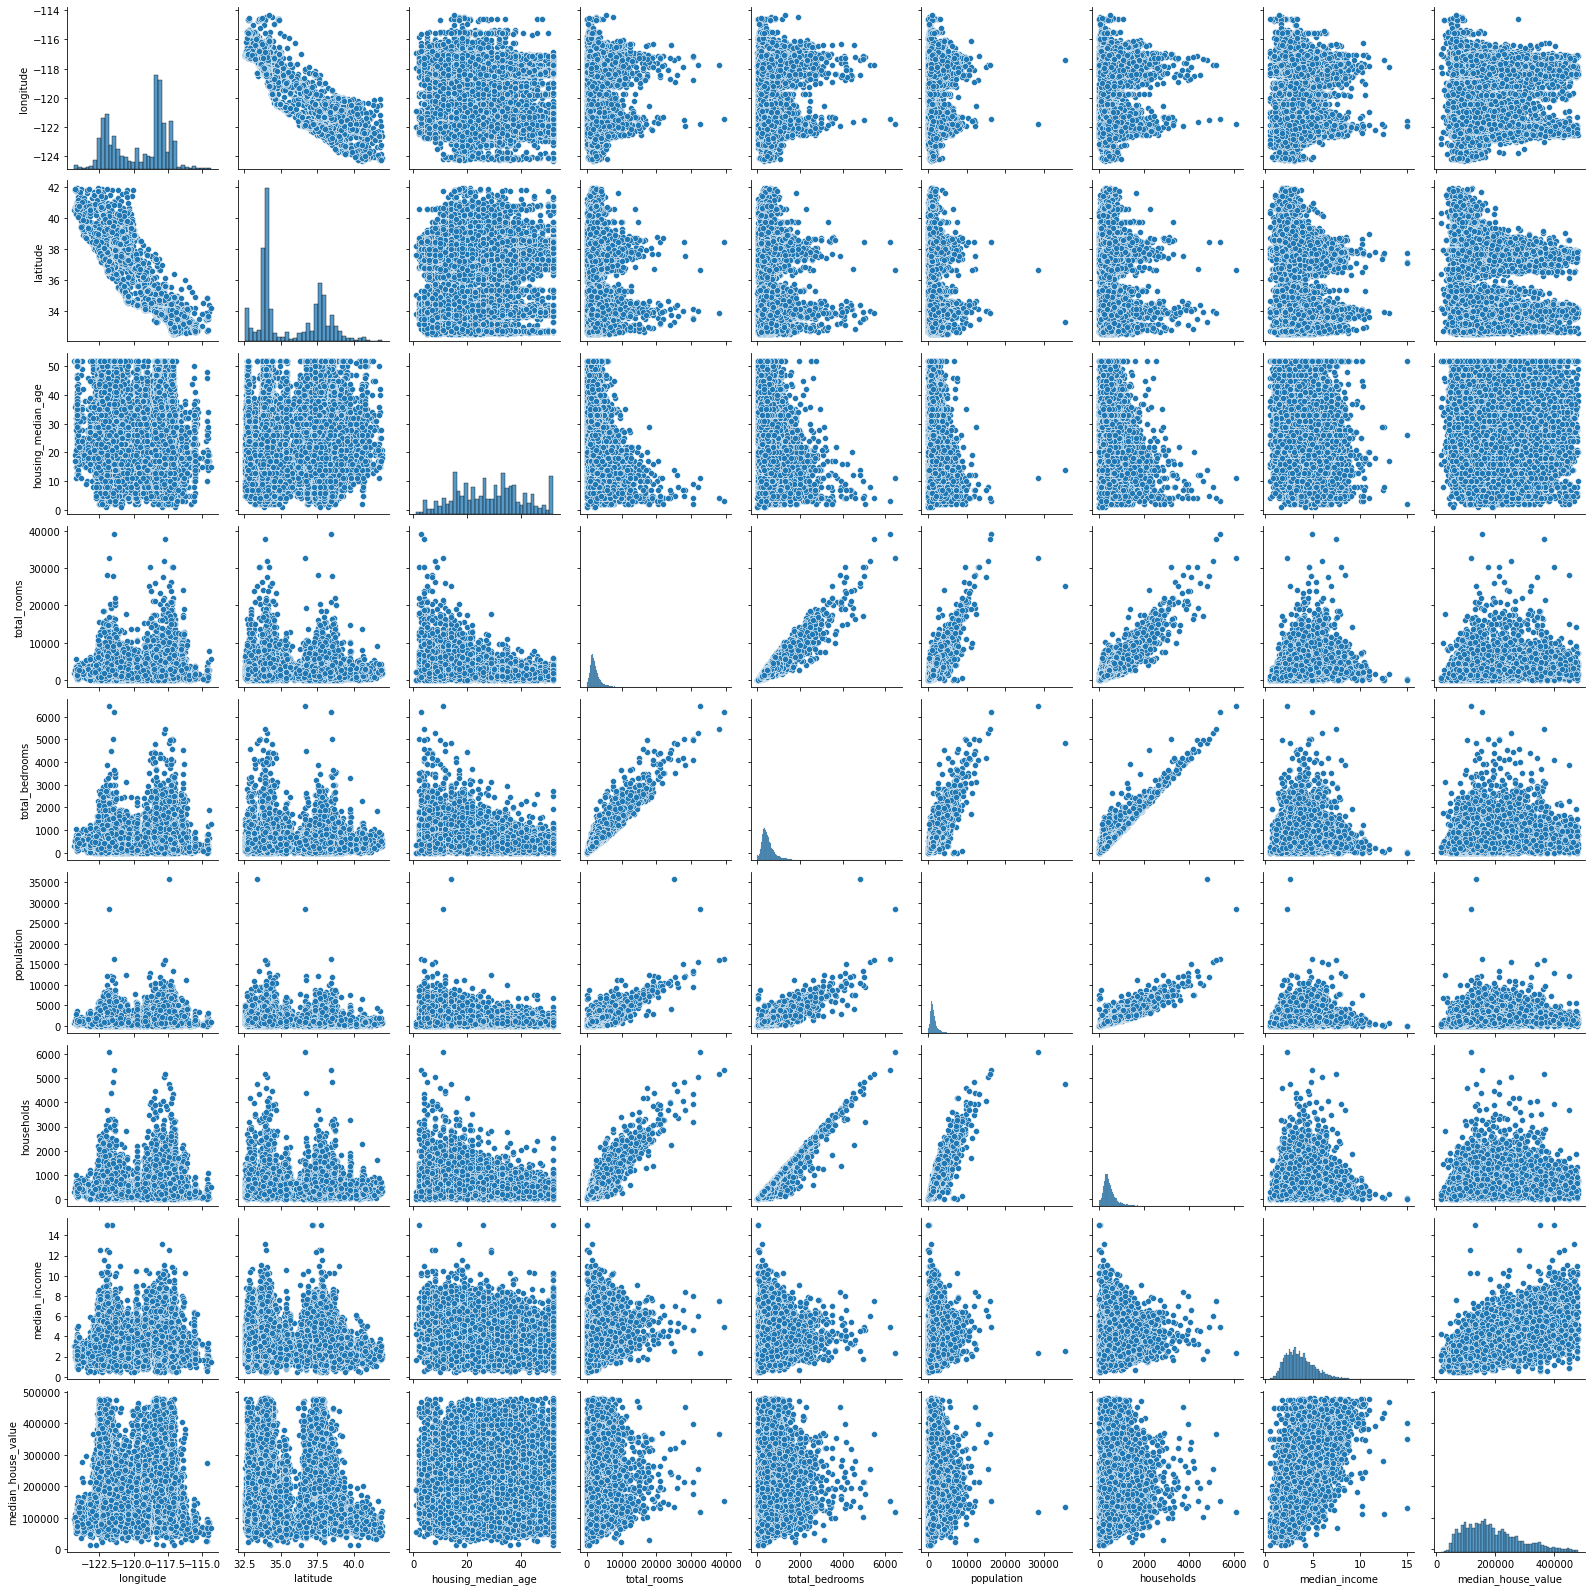

In [12]:
sns.pairplot(df_housing.toPandas());

In [13]:
for i in df_housing.columns:
    if not(isinstance(df_housing.select(i).take(1)[0][0], six.string_types)):
        print("Correlation to `median_house_value` for ", i, df_housing.stat.corr('median_house_value',i))

Correlation to `median_house_value` for  longitude -0.047537278969730104
Correlation to `median_house_value` for  latitude -0.14895284415699642
Correlation to `median_house_value` for  housing_median_age 0.06228651606013993
Correlation to `median_house_value` for  total_rooms 0.1461129610070606
Correlation to `median_house_value` for  total_bedrooms 0.07863368860925843
Correlation to `median_house_value` for  population 0.016787217983470444
Correlation to `median_house_value` for  households 0.0982652075929121
Correlation to `median_house_value` for  median_income 0.6436893384339446
Correlation to `median_house_value` for  median_house_value 1.0


Самая большая корреляция наблюдается с признаком `median_income`: 0.6880752079585578. 

**Вывод**

Явных дубликатов в данных не выявлено. 

В столбце `total_bedrooms` обнаружены пропуски. Учитывая, что доля пропусков составляет 1% от выборки, принято решение эти данные удалить. 

Значения целевой переменной > 480000 решено считать вбросами.

Максимальная корреляция целевой переменной наблюдается с признаком `median_income`: 0.6880752079585578.

## Подготовка данных

In [14]:
df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



Разделим колонки на два типа: числовые и текстовые, которые представляют категориальные данные.

In [15]:
categorical = ['ocean_proximity']
target = ['median_house_value']
numerical  = [col for col in df_housing.columns if col not in categorical+target]

### Tрансформация категорийных признаков

In [16]:
indexer = StringIndexer(inputCols=categorical, 
                        outputCols=[c+'_idx' for c in categorical]) 
df_housing = indexer.fit(df_housing).transform(df_housing)

In [17]:
encoder = OneHotEncoder(inputCols=[c+'_idx' for c in categorical],
                        outputCols=[c+'_ohe' for c in categorical])
df_housing = encoder.fit(df_housing).transform(df_housing)

In [18]:
df_housing.toPandas().head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_idx,ocean_proximity_ohe
0,-122.28,37.81,52.0,340.0,97.0,200.0,87.0,1.5208,112500.0,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)"
1,-122.13,37.67,40.0,1748.0,318.0,914.0,317.0,3.8676,184000.0,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)"
2,-122.07,37.67,27.0,3239.0,671.0,1469.0,616.0,3.2465,230600.0,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)"
3,-122.13,37.66,19.0,862.0,167.0,407.0,183.0,4.3456,163000.0,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)"
4,-121.85,39.73,52.0,444.0,80.0,1107.0,98.0,3.4191,137500.0,INLAND,1.0,"(0.0, 1.0, 0.0, 0.0)"


Преобразуем категорийные признаки в вектор.

In [19]:
categorical_assembler = VectorAssembler(inputCols=[c+'_ohe' for c in categorical],
                                        outputCol='categorical_features')
df_housing = categorical_assembler.transform(df_housing) 

### Трансформация числовых признаков

In [20]:
numerical_assembler = VectorAssembler(inputCols=numerical,
                                      outputCol='numerical_features')
df_housing = numerical_assembler.transform(df_housing) 

In [21]:
standardScaler = StandardScaler(inputCol='numerical_features',
                                outputCol='numerical_features_scaled')
df_housing = standardScaler.fit(df_housing).transform(df_housing) 

Объединим категорийные и числовые признаки в вектор.

In [22]:
all_features = ['categorical_features','numerical_features_scaled']
final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol='features') 
df_housing = final_assembler.transform(df_housing)

In [23]:
df_housing.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'ocean_proximity_idx',
 'ocean_proximity_ohe',
 'categorical_features',
 'numerical_features',
 'numerical_features_scaled',
 'features']

### Разделение на выборки

In [24]:
train_data, test_data = df_housing.randomSplit([.8,.2], seed=RANDOM_SEED)
print(train_data.count(), test_data.count()) 

15502 3859


**Вывод**

Категориальные данные преобразованы методом One Hot Encoding.
Числовые данные приведены к единому масштабу.

Данные разделены на тренировочную и тестовую выборки в пропорции 80/20.

## Обучение моделей

Создадим функцию для оценки моделей.

In [25]:
def evaluation(x, name):
    evaluation_summary = x.bestModel.evaluate(test_data)
    print(name)
    print('MAE: ', evaluation_summary.meanAbsoluteError)
    print('RMSE: ', evaluation_summary.rootMeanSquaredError) 
    print('R2: ', evaluation_summary.r2)   
    print('') 

### Линейная регрессия на базе категориальных и числовых данных

In [26]:
lin_reg_1 = LinearRegression(labelCol='median_house_value', featuresCol='features')

In [27]:
grid_search = ParamGridBuilder() \
    .addGrid(lin_reg_1.regParam, [0.01, 0.02, 0.05, 0.08, 0.1]) \
    .addGrid(lin_reg_1.elasticNetParam, [0.5, 1.0]) \
    .build()

In [28]:
%%time

evaluator = RegressionEvaluator(predictionCol='prediction',
                                labelCol='median_house_value')

cv = CrossValidator(estimator=lin_reg_1,
                    estimatorParamMaps=grid_search,
                    evaluator=evaluator,
                    numFolds=3)
model_1 = cv.fit(train_data)

CPU times: total: 1.03 s
Wall time: 8min 17s


In [29]:
evaluation(model_1, 'model_all_features')

model_all_features
MAE:  43576.99016368426
RMSE:  58742.55578459087
R2:  0.6333943918288811



### Линейная регрессия на базе числовых данных

In [30]:
lin_reg_2 = LinearRegression(labelCol='median_house_value', featuresCol='numerical_features_scaled')

In [31]:
grid_search = ParamGridBuilder() \
    .addGrid(lin_reg_2.regParam, [0.01, 0.02, 0.05, 0.08, 0.1]) \
    .addGrid(lin_reg_2.elasticNetParam, [0.5, 1.0]) \
    .build()

In [32]:
%%time

evaluator = RegressionEvaluator(predictionCol='prediction',
                                labelCol='median_house_value')

cv = CrossValidator(estimator=lin_reg_2,
                    estimatorParamMaps=grid_search,
                    evaluator=evaluator,
                    numFolds=3)
model_2 = cv.fit(train_data)

CPU times: total: 1.14 s
Wall time: 8min 18s


In [33]:
evaluation(model_2, 'model_numeric_features')

model_numeric_features
MAE:  44811.81899030967
RMSE:  59689.62845297829
R2:  0.6214779534692787



**Вывод**

Результаты работы моделей на тестовой выборке:

In [34]:
evaluation(model_1, 'model_all_features')
evaluation(model_2, 'model_numeric_features')

model_all_features
MAE:  43576.99016368426
RMSE:  58742.55578459087
R2:  0.6333943918288811

model_numeric_features
MAE:  44811.81899030967
RMSE:  59689.62845297829
R2:  0.6214779534692787



## Анализ результатов

Метрики модели линейной регресии на базе числовых и категориальных данных оказались несколько лучше показателей модели без категориальных признаков. Разница при этом незначительная.

Среднее значение стоимости жилья в первоначальных данных - 206855.82. Лучшие метрики при этом:

 - MAE:  43211.797088283274
 - RMSE:  57862.287129905955
 - R2:  0.6316594805616227.

Модель совершает достаточно значимые ошибки, вероятно в дальнейшем стоит увеличить размерность данных или применить более сложные модели.